In [15]:
import pandas as pd
penguins = pd.read_csv('penguins.csv')
penguins

,CulmenLength,CulmenDepth,FlipperLength,BodyMass,Species
0,39.1,18.7,181.0,3750.0,0
1,39.5,17.4,186.0,3800.0,0
2,40.3,18.0,195.0,3250.0,0
3,NaN,NaN,NaN,NaN,0
4,36.7,19.3,193.0,3450.0,0
...,...,...,...,...,...
339,55.8,19.8,207.0,4000.0,2
340,43.5,18.1,202.0,3400.0,2
341,49.6,18.2,193.0,3775.0,2
342,50.8,19.0,210.0,4100.0,2


In [18]:
penguins=penguins.dropna()
features = ['CulmenLength', 'CulmenDepth', 'FlipperLength', 'BodyMass']
target = 'Species'
x, y = penguins[features], penguins[target]

In [20]:
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state =0, stratify = y)

In [21]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, f1_score, roc_auc_score
from sklearn.preprocessing import label_binarize
from sklearn.neighbors import KNeighborsClassifier

# Inicjalizacja zbiorów metryk i modeli
metrics_dataframe = pd.DataFrame(columns=['Model', 'F1_score', 'AUC'])
models = []
models_names = []
predictions_proba_list = []

def calculate_metrics(model, name, X_checked, y_checked):
    global metrics_dataframe

    predictions = model.predict(X_checked)
    predictions_proba = model.predict_proba(X_checked)

    # Dodajemy do zbioru tylko bieżący model
    print(classification_report(y_checked, predictions))

    # Macierz pomyłek
    plt.figure()
    cm = confusion_matrix(y_checked, predictions)
    ax = sns.heatmap(cm, annot=True, cmap='Blues', fmt='.0f')
    ax.set_title(f'Confusion Matrix - {name}')
    ax.set_xlabel('Predicted')
    ax.set_ylabel('Actual')
    plt.show()

    # Multiclass ROC
    classes = sorted(np.unique(y_checked))
    y_binarized = label_binarize(y_checked, classes=classes)

    fig = plt.figure(figsize=(6, 6))
    plt.plot([0, 1], [0, 1], 'k--')

    for i, class_label in enumerate(classes):
        fpr, tpr, _ = roc_curve(y_binarized[:, i], predictions_proba[:, i])
        plt.plot(fpr, tpr, label=f'{name} (class {class_label})')

    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve - {name}')
    plt.legend(loc='lower right')
    plt.show()

    # Metryki
    f1_metric = f1_score(y_checked, predictions, average='macro')
    auc_metric = roc_auc_score(y_binarized, predictions_proba, multi_class='ovr')

    new_row = pd.DataFrame([{
        'Model': name,
        'F1_score': f1_metric,
        'AUC': auc_metric
    }])

    metrics_dataframe = pd.concat([metrics_dataframe, new_row], ignore_index=True)

    #print("\n📊 Podsumowanie metryk:")
    #print(metrics_dataframe)

    return metrics_dataframe


# Funkcja: wizualizacja granicy decyzyjnej
def plot_classification_surface(model, X, y, title=""):
    h = .02
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    plt.figure(figsize=(6, 5))
    scatter = plt.scatter(X[:, 0], X[:, 1], c=y, edgecolors='k', cmap=plt.cm.coolwarm)
    plt.contourf(xx, yy, Z, alpha=0.3, cmap=plt.cm.coolwarm)
    plt.xlabel("CulmenLength")
    plt.ylabel("FlipperLength")
    plt.title(title)
    handles, labels = scatter.legend_elements()
    plt.legend(handles, labels, title="Class", loc="upper right")
    plt.show()




In [12]:
#KNN / Tree mają najwyższy F1-score – czyli radzą sobie świetnie z klasyfikacją wszystkich klas równomiernie.

#Logistic Regression ma najwyższe AUC – czyli najlepiej odróżnia klasy (nawet jeśli np. na jednej klasie mu idzie lepiej niż na innych).

#Random Forest (rf_model_v2) jest kompromisem – ma bardzo wysokie AUC i niezły F1-score.



SyntaxError: invalid syntax (487571100.py, line 7)

Fitting 5 folds for each of 16 candidates, totalling 80 fits

Best hyperparameter: {'max_depth': 3, 'min_samples_leaf': 5}
              precision    recall  f1-score   support

           0       0.94      1.00      0.97        30
           1       1.00      1.00      1.00        25
           2       1.00      0.86      0.92        14

    accuracy                           0.97        69
   macro avg       0.98      0.95      0.96        69
weighted avg       0.97      0.97      0.97        69



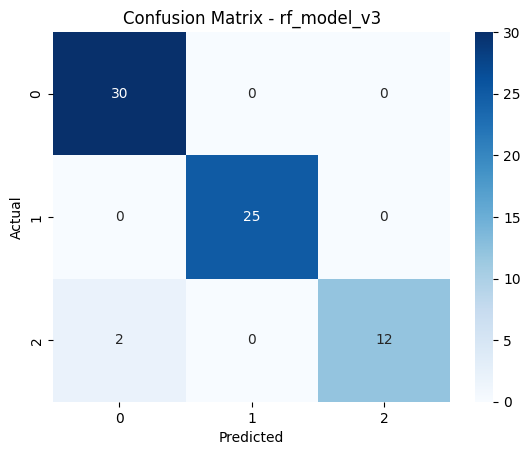

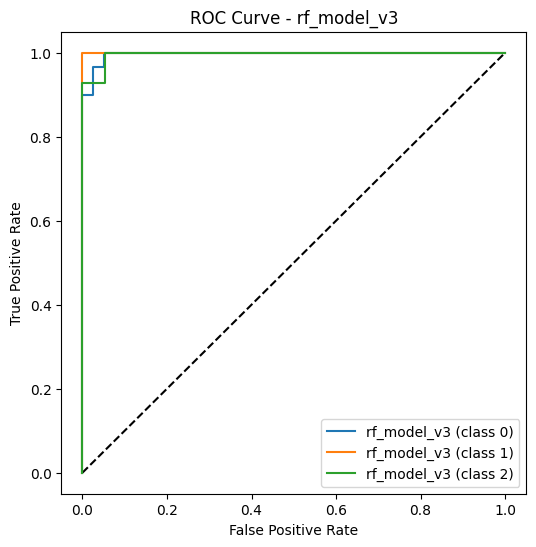

C:\Users\DarkRaziel\AppData\Local\Temp\ipykernel_4532\3132036197.py:60: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  metrics_dataframe = pd.concat([metrics_dataframe, new_row], ignore_index=True)


,Model,F1_score,AUC
0,rf_model_v3,0.963606,0.997562


In [23]:
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

pca = PCA(n_components=0.95)  # lub np. n_components=10
X_train = pca.fit_transform(X_train)
X_test = pca.transform(X_test)


random_forest = RandomForestClassifier(n_estimators=1000, n_jobs=-1)
params_rf = {
    'max_depth': [3, 5, 10, 20],
    'min_samples_leaf': [3, 5, 10, 15]
}
rf_gridsearch = GridSearchCV(
    random_forest,
    params_rf,
    scoring='f1_macro',
    cv=5,
    verbose=10,
    n_jobs=-1
)
rf_gridsearch.fit(X_train, y_train)

print('\nBest hyperparameter:', rf_gridsearch.best_params_)

rf_model_v3 = rf_gridsearch.best_estimator_
calculate_metrics(rf_model_v3, 'rf_model_v3', X_test, y_test)

In [24]:
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
pipe = Pipeline([
    ('scaler', StandardScaler()),         
    ('pca', PCA(n_components=0.95)),       
    ('logreg', LogisticRegression(max_iter=10000, solver='saga'))  
])


param_grid = {
    'logreg__C': [0.01, 0.1, 1, 10, 100],   # Regularyzacja C
    'logreg__penalty': ['l1', 'l2']          # Typ regularyzacji
}

grid_search = GridSearchCV(pipe, param_grid, scoring='f1_macro', cv=5, verbose=10, n_jobs=-1)

grid_search.fit(X_train, y_train)


print('\nBest hyperparameters:', grid_search.best_params_)
best_model = grid_search.best_estimator_


test_score = best_model.score(X_test, y_test)
print(f'\nTest accuracy: {test_score:.4f}')

Fitting 5 folds for each of 10 candidates, totalling 50 fits

Best hyperparameters: {'logreg__C': 1, 'logreg__penalty': 'l1'}

Test accuracy: 0.9855


              precision    recall  f1-score   support

           0       0.97      1.00      0.98        30
           1       1.00      1.00      1.00        25
           2       1.00      0.93      0.96        14

    accuracy                           0.99        69
   macro avg       0.99      0.98      0.98        69
weighted avg       0.99      0.99      0.99        69



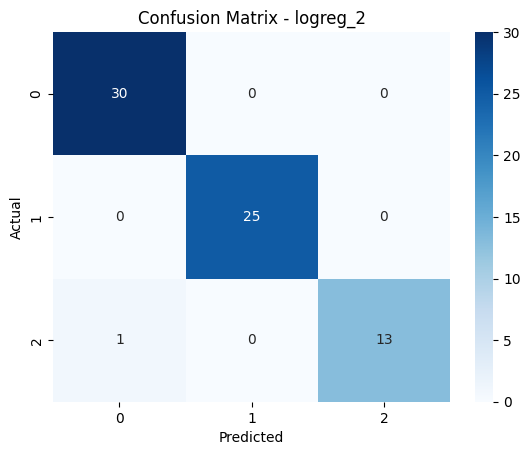

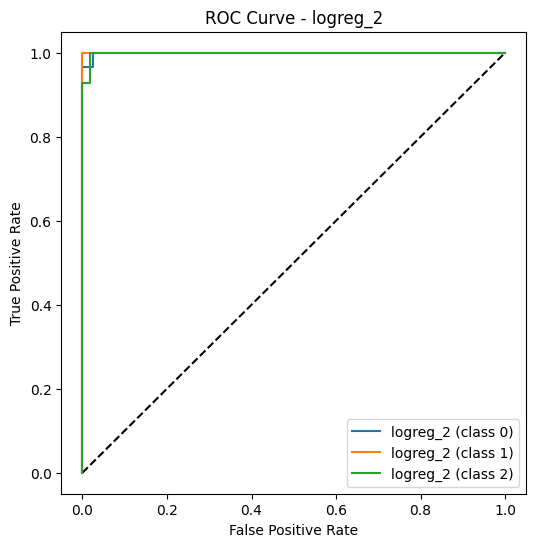

,Model,F1_score,AUC
0,rf_model_v3,0.963606,0.997562
1,logreg_2,0.982190,0.999282


In [25]:
calculate_metrics(best_model, 'logreg_2', X_test, y_test)

In [40]:
print(f"Modele z użytym PCA (rf_model_v3 oraz logreg_2) wyglądają lepiej niż wcześniejsze, "
      f"w których nie została użyta redukcja wymiarowości. RF z PCA wynosi {rf_model_v3.score(X_test, y_test):.2f} podczas gdy wcześniejszy model" 
      f"miał tylko 0,94."
      f"Sytuacja wygląda podobnie dla regresji logistycznej: nowy model {test_score:.2f} stary 0,94 (model działał na 2 najbardziej skolerowanych "
      f"cech ze zmienna docelową )")





Modele z użytym PCA (rf_model_v3 oraz logreg_2) wyglądają lepiej niż wcześniejsze, w których nie została użyta redukcja wymiarowości. RF z PCA wynosi 0.97 podczas gdy wcześniejszy modelmiał tylko 0,94.Sytuacja wygląda podobnie dla regresji logistycznej: nowy model 0.99 stary 0,94 (model działał na 2 najbardziej skolerowanych cech ze zmienna docelową )
